## Perform analysis of cardiomyocytes from all Boston & Cambridge samples to date

Catherine L Worth, MDC Berlin
<br>
2020 07 20
<br>
catherine.sargent@mdc-berlin.de

Pre-filtering of cardiomyocytes. End object to be used for further subclustering analysis of atrial and ventricular cardiomyocytes.

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import glob
import bbknn
import os, fnmatch
import requests
import io
import seaborn as sns
import scipy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi = 100, color_map = 'RdBu_r')

/gnu/var/guix/profiles/custom/huebner-sc/.guix-profile/lib/python3.7/site-packages/louvain/Optimiser.py:349: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(issubclass(partition_type, LinearResolutionParameterVertexPartition),


In [2]:
def multivariateGrid(col_x, col_y, col_k, df, k_is_color=False, scatter_alpha=.5, scatter_size=4):
    def colored_scatter(x, y, c=None, scatter_size=scatter_size):
        def scatter(*args, **kwargs):
            args = (x, y)
            if c is not None:
                kwargs['c'] = c
            kwargs['alpha'] = scatter_alpha
            plt.scatter(*args, **kwargs, s=scatter_size)

        return scatter

    g = sns.JointGrid(
        x=col_x,
        y=col_y,
        data=df
    )
    color = None
    legends=[]
    for name, df_group in df.groupby(col_k):
        legends.append(name)
        if k_is_color:
            color=name
        g.plot_joint(
            colored_scatter(df_group[col_x],df_group[col_y],color),
        )
        sns.distplot(
            df_group[col_x].values,
            ax=g.ax_marg_x,
            color=color,
        )
        sns.distplot(
            df_group[col_y].values,
            ax=g.ax_marg_y,
            color=color,            
            vertical=True
        )

    plt.legend(legends)

In [3]:
def densityplot(xdat, ydat, xlab, ylab):
    
    #histogram definition
    xyrange = [[min(xdat),max(xdat)],[min(ydat),max(ydat)]] # data range
    bins = [100,100] # number of bins
    thresh = 3  #density threshold

    # histogram the data
    hh, locx, locy = scipy.histogram2d(xdat, ydat, range=xyrange, bins=bins)
    posx = np.digitize(xdat, locx)
    posy = np.digitize(ydat, locy)

    #select points within the histogram
    ind = (posx > 0) & (posx <= bins[0]) & (posy > 0) & (posy <= bins[1])
    hhsub = hh[posx[ind] - 1, posy[ind] - 1] # values of the histogram where the points are
    xdat1 = xdat[ind][hhsub < thresh] # low density points
    ydat1 = ydat[ind][hhsub < thresh]
    hh[hh < thresh] = np.nan # fill the areas with low density by NaNs
    
    
    plt.imshow(np.flipud(hh.T),cmap='jet',extent=np.array(xyrange).flatten(), interpolation='none', origin='upper', aspect='auto')
    #plt.colorbar()   
    plt.plot(xdat1, ydat1, '.',color='darkblue')
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.show()

In [4]:
parent_path = '/fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/'
current_results_round = '20200629'

date_dir = parent_path + current_results_round + '/'

if not os.path.exists(date_dir):
    os.makedirs(date_dir, mode=0o775)

In [5]:
analysis = 'cms'
analysis_dir = date_dir + analysis + "/"

if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir, mode=0o775)

In [6]:
results_dir = analysis_dir + 'Results/'

if not os.path.exists(results_dir):
    os.makedirs(results_dir, mode=0o775)

In [7]:
sc.settings.figdir = results_dir + 'Figures/'

if not os.path.exists(sc.settings.figdir):
    os.makedirs(sc.settings.figdir, mode=0o775)

In [8]:
tables_dir = results_dir + 'Tables/'

if not os.path.exists(tables_dir):
    os.makedirs(tables_dir, mode=0o775)

In [11]:
input_file = '/fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200423/global/Results/Subclusters/Heart_cardiomyocytes_20200423_RAW.h5ad'
raw_filtered_file = results_dir + 'Bos_Cam_cardiomyocytes_RAW_' + current_results_round + '_processed.h5ad'

In [12]:
CB_BOS_cm_all = sc.read_h5ad(input_file)

In [13]:
CB_BOS_cm_all.shape

(159266, 33538)

In [14]:
CB_BOS_cm_all.obs['cell_source'].cat.categories

Index(['Harvard-Nuclei', 'Sanger-CD45', 'Sanger-Cells', 'Sanger-Nuclei'], dtype='object')

Only use nuclei data for downstream analysis (exclude total and CD45+ cells)

In [15]:
CB_BOS_cm = CB_BOS_cm_all[CB_BOS_cm_all.obs['cell_source'].isin(['Harvard-Nuclei', 'Sanger-Nuclei'])]

In [16]:
CB_BOS_cm.shape

(157653, 33538)

Excluded cells are stored in CB_BOS_cm_cells (1613 cells)

In [17]:
CB_BOS_cm_cells = CB_BOS_cm_all[~CB_BOS_cm_all.obs['cell_source'].isin(['Harvard-Nuclei', 'Sanger-Nuclei'])]

In [18]:
CB_BOS_cm_cells.shape

(1613, 33538)

In [19]:
CB_BOS_cm.obs['Center']=CB_BOS_cm.obs['cell_source']
subs = {
   "Harvard-Nuclei":"Harvard",
   "Sanger-CD45":"Sanger",
   "Sanger-Cells":"Sanger",
   "Sanger-Nuclei":"Sanger", 
    }
x=[subs.get(item,item)  for item in CB_BOS_cm.obs['Center']]
CB_BOS_cm.obs['Center']=x

### Filtering of cardiomyocytes

... storing 'Center' as categorical


saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/cms/Results/Figures/violin_CMs_QC_prefiltered.png


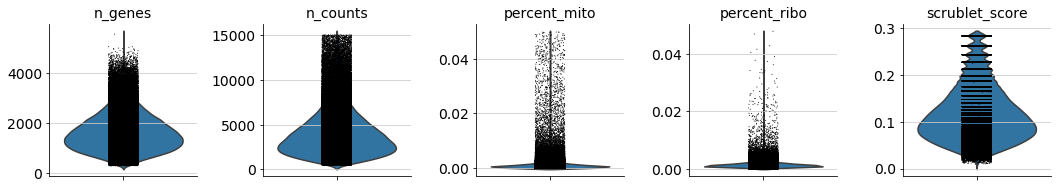

In [20]:
sc.pl.violin(CB_BOS_cm, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'],
             jitter=0.1, multi_panel=True, save = '_CMs_QC_prefiltered.png')

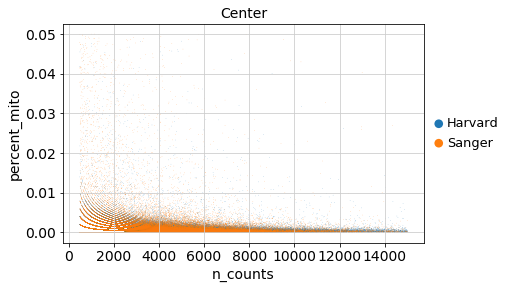

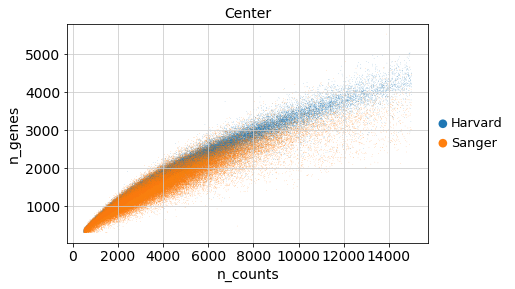

In [21]:
sc.pl.scatter(CB_BOS_cm, x='n_counts', y='percent_mito', color='Center')
sc.pl.scatter(CB_BOS_cm, x='n_counts', y='n_genes', color='Center')

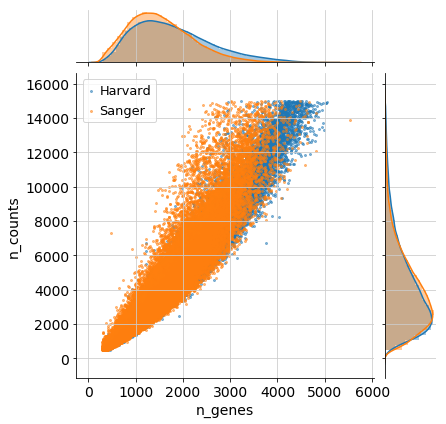

In [22]:
multivariateGrid('n_genes', 'n_counts', 'Center', CB_BOS_cm.obs, k_is_color=False, scatter_alpha=.5, scatter_size=4)

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/cms/Results/Figures/violin_CMs_QC_prefiltered_institute.png


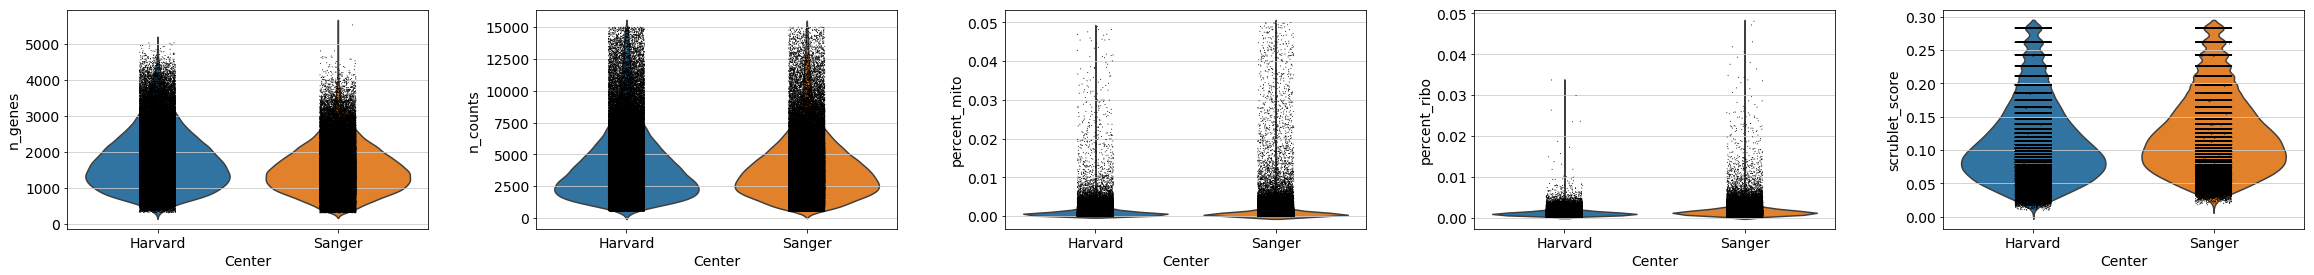

In [23]:
sc.pl.violin(CB_BOS_cm, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'],
             jitter=0.1, groupby ='Center', save = '_CMs_QC_prefiltered_institute.png')

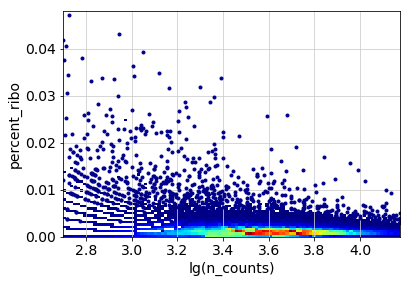

In [24]:
densityplot(np.log10(CB_BOS_cm.obs['n_counts']), CB_BOS_cm.obs['percent_ribo'], 'lg(n_counts)', 'percent_ribo')

In [25]:
np.min(CB_BOS_cm.obs['n_genes'])

301

In [26]:
np.min(CB_BOS_cm.obs['n_counts'])

501.0

Use stricter filtering cut-offs for n_counts and n_genes (reduce the maximum cut-off for both). Cut-off chosen based on density plot shown above.

In [27]:
sc.pp.filter_cells(CB_BOS_cm, max_genes=4000)

filtered out 1047 cells that have more than  4000 genes expressed


In [28]:
CB_BOS_cm = CB_BOS_cm[CB_BOS_cm.obs['n_counts'] < 12500, :]

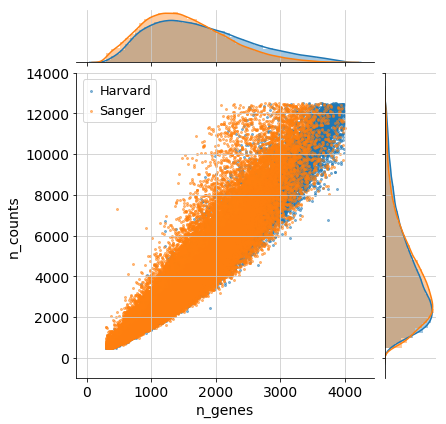

In [29]:
multivariateGrid('n_genes', 'n_counts', 'Center', CB_BOS_cm.obs, k_is_color=False, scatter_alpha=.5, scatter_size=4)

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/cms/Results/Figures/violin_CMs_QC_filtered_institute.png


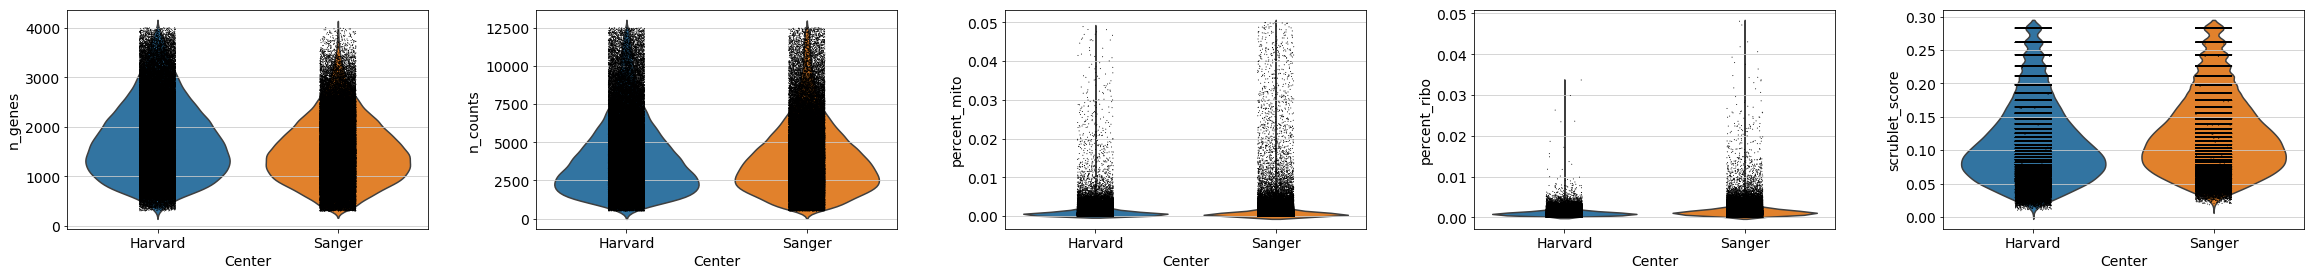

In [30]:
sc.pl.violin(CB_BOS_cm, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'],
             jitter=0.1, groupby ='Center', save = '_CMs_QC_filtered_institute.png')

Use stricter filtering cutoffs for percent_ribo, percent_mito and scrublet_score (based on violin plots above)

In [31]:
CB_BOS_cm = CB_BOS_cm[CB_BOS_cm.obs['percent_ribo'] < 0.01, :]

In [32]:
CB_BOS_cm = CB_BOS_cm[CB_BOS_cm.obs['percent_mito'] < 0.01, :]

In [34]:
temp_copy = CB_BOS_cm.copy()

In [35]:
CB_BOS_cm = temp_copy[temp_copy.obs['scrublet_score'] < 0.25, :]

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/cms/Results/Figures/violin_CMs_QC_filtered_institute.png


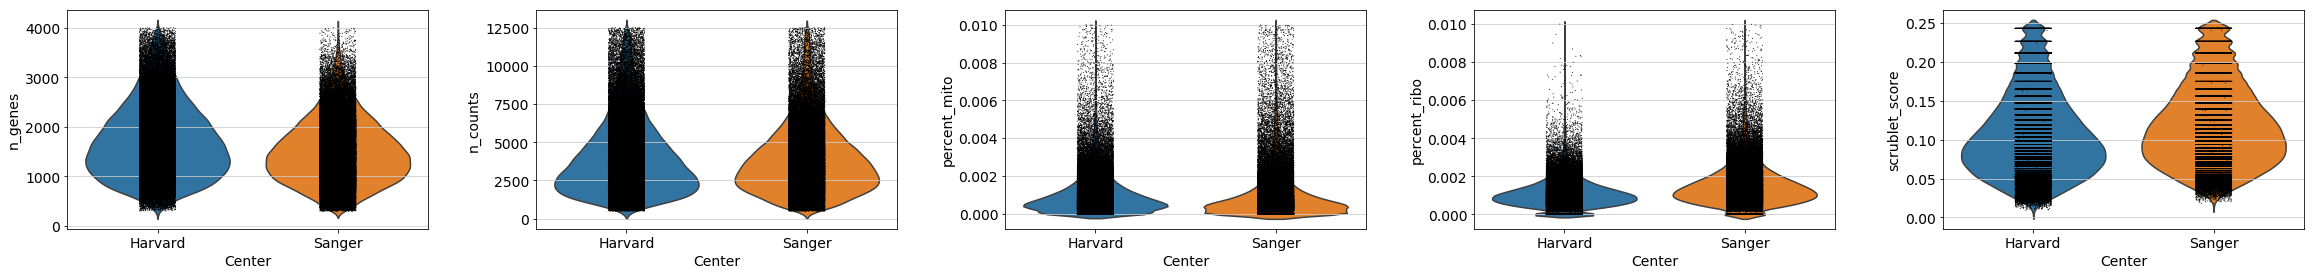

In [36]:
sc.pl.violin(CB_BOS_cm, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'],
             jitter=0.1, groupby ='Center', save = '_CMs_QC_filtered_institute.png')

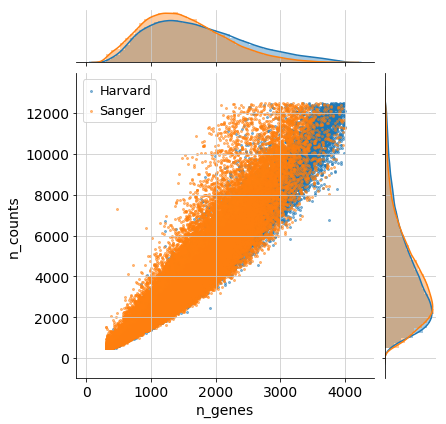

In [37]:
multivariateGrid('n_genes', 'n_counts', 'Center', CB_BOS_cm.obs, k_is_color=False, scatter_alpha=.5, scatter_size=4)

In [38]:
CB_BOS_cm.shape

(148772, 33538)

saving figure to file /fast/AG_Huebner/huebner3/ANALYSES/20191112_cs_HH_England/scanpy/20200629/cms/Results/Figures/violin_CMs_QC_filtered.png


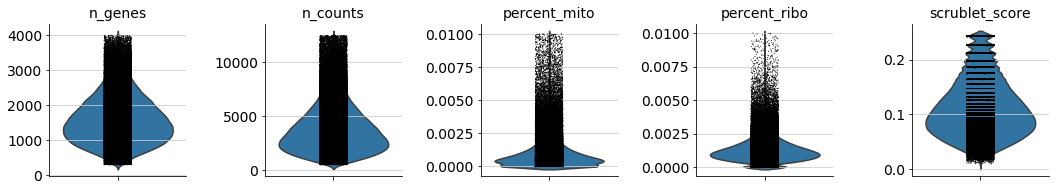

In [39]:
sc.pl.violin(CB_BOS_cm, ['n_genes', 'n_counts', 'percent_mito', 'percent_ribo', 'scrublet_score'],
             jitter=0.1, multi_panel=True, save = '_CMs_QC_filtered.png')

In [40]:
CB_BOS_cm.write(raw_filtered_file)